## C. Analysis and Discussion

We compare deterministic vs stochastic learning, analyze the effect of slip probability, hole number/placement, and the influence of α, γ, and ε-decay on training and policy quality.


## B. Q-Learning for FrozenLake

We implement Q-learning with ε-greedy exploration. We train until the cumulative reward converges, then visualize learning curves and generate policy GIFs.


## A. Game Description

1) 8×8 grid lake; agent starts at (0,0), goal at (7,7); holes cause failure.
2) Actions: up, down, left, right; out-of-bounds leaves state unchanged.
3) Tiles include start (S), frozen (F), hole (H), goal (G).
4) Dynamics:
   - Case 1: Deterministic (`is_slippery=False`) — intended move always succeeds.
   - Case 2: Stochastic (`is_slippery=True`) — intended move succeeds with limited probability.
5) Episodes end on reaching goal, falling into hole, or step limit.
6) Objective: learn an optimal policy maximizing cumulative reward in both dynamics.


# IV. Reinforcement Learning for Game: FrozenLake-v1 (8×8)

This notebook follows the assignment structure:

- A. Game Description
- B. Q-Learning for FrozenLake
- C. Analysis and Discussion


## 1. Import Required Libraries

In [32]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    import pickle5 as pickle
except ImportError:
    import pickle

## 2. Create FrozenLake 8×8 Environment

- **Map size**: 8×8 grid (64 states)
- **Slippery**: Set to `False` for deterministic movement (change to `True` for stochastic)
- **Render mode**: `rgb_array` for video recording

In [33]:
# Create 8x8 FrozenLake environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array")

print("Environment created successfully!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment created successfully!
Observation space: Discrete(64)
Action space: Discrete(4)


## 3. Explore the Environment

**Observation Space**: Discrete(64) - represents agent's position as `row * 8 + col`

**Action Space**: Discrete(4)
- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

In [34]:
# Get state and action space sizes
state_space = env.observation_space.n
action_space = env.action_space.n

print(f"State space size: {state_space}")
print(f"Action space size: {action_space}")
print(f"\nGoal position (7,7) = state {7 * 8 + 7} = 63")

State space size: 64
Action space size: 4

Goal position (7,7) = state 63 = 63


## 4. Initialize Q-Table

Q-table shape: (state_space, action_space) = (64, 4)

All values initialized to 0.

In [35]:
def initialize_q_table(state_space, action_space):
    """Initialize Q-table with zeros."""
    return np.zeros((state_space, action_space))

# Create Q-table
Qtable = initialize_q_table(state_space, action_space)
print(f"Q-table shape: {Qtable.shape}")
print(f"Q-table initialized with zeros.")

Q-table shape: (64, 4)
Q-table initialized with zeros.


## 5. Define Policies

### Greedy Policy (Exploitation)
Selects action with highest Q-value for given state.

### Epsilon-Greedy Policy (Exploration + Exploitation)
- With probability (1 - ε): exploit (use greedy policy)
- With probability ε: explore (random action)

In [36]:
def greedy_policy(Qtable, state):
    """Select action with highest Q-value for given state."""
    return np.argmax(Qtable[state][:])

def epsilon_greedy_policy(Qtable, state, epsilon):
    """Epsilon-greedy policy for exploration-exploitation tradeoff."""
    random_num = random.uniform(0, 1)
    
    if random_num > epsilon:
        # Exploitation: choose best action
        action = greedy_policy(Qtable, state)
    else:
        # Exploration: random action
        action = env.action_space.sample()
    
    return action

print("Policies defined successfully!")

Policies defined successfully!


## 6. Set Hyperparameters

Key parameters for Q-Learning algorithm:
- **Learning rate (α)**: How much to update Q-values
- **Discount factor (γ)**: Importance of future rewards
- **Epsilon decay**: Controls exploration reduction over time

### ⚠️ Common Convergence Issues for 8×8 Grid

**Problem**: Q-table stays all zeros → Agent never learns

**Root causes**:
1. **Epsilon decay too fast**: Agent stops exploring before finding goal
   - With `decay_rate=0.0005`, epsilon drops too quickly for 64 states
   - Solution: Use `decay_rate=0.00001` (50× slower)

2. **Not enough episodes**: 8×8 grid needs more exploration than 4×4
   - 100k episodes is good, but only if epsilon stays high enough

3. **Learning rate too low**: Updates too small
   - `learning_rate=0.7` is good for this problem

**Good values for 8×8**:
- `decay_rate = 0.00001` (keeps epsilon high longer)
- `min_epsilon = 0.01` (always some exploration)
- `n_training_episodes = 100000+` (more episodes)
- `learning_rate = 0.7` (faster learning)

In [37]:
# Training parameters
n_training_episodes = 100000   # Increased for 8x8 (more complex)
learning_rate = 0.7           # Learning rate (alpha)

# Evaluation parameters
n_eval_episodes = 100         # Number of evaluation episodes

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 199               # Max steps per episode (increased for 8x8)
gamma = 0.95                  # Discount factor
eval_seed = []                # Evaluation seeds

# Exploration parameters - FIXED for 8x8 convergence
max_epsilon = 1.0             # Start with full exploration
min_epsilon = 0.01            # Lower minimum (more exploration)
decay_rate = 0.00001          # MUCH slower decay for 8x8 (was 0.0005)

print("Hyperparameters set:")
print(f"  Training episodes: {n_training_episodes}")
print(f"  Learning rate: {learning_rate}")
print(f"  Gamma: {gamma}")
print(f"  Epsilon: {max_epsilon} → {min_epsilon} (decay: {decay_rate})")
print(f"  Max steps per episode: {max_steps}")
print(f"\nNote: Slower epsilon decay for 8x8 grid - allows more exploration!")

Hyperparameters set:
  Training episodes: 100000
  Learning rate: 0.7
  Gamma: 0.95
  Epsilon: 1.0 → 0.01 (decay: 1e-05)
  Max steps per episode: 199

Note: Slower epsilon decay for 8x8 grid - allows more exploration!


## 7. Training Function

Q-Learning update rule:

$$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$$

Where:
- $Q(s,a)$: Current Q-value
- $\alpha$: Learning rate
- $r$: Reward
- $\gamma$: Discount factor
- $s'$: Next state
- $\max_{a'} Q(s',a')$: Maximum Q-value for next state

In [38]:
def train_with_logging(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, log_interval=10000):
    """
    Train Q-Learning agent with progress logging.
    
    Returns:
        Qtable: Updated Q-table
        metrics: Dictionary with training metrics
    """
    success_count = 0
    episode_rewards = []
    
    for episode in tqdm(range(n_training_episodes)):
        # Decay epsilon (reduce exploration over time)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        # Reset environment
        state, info = env.reset()
        terminated = False
        truncated = False
        episode_reward = 0
        
        # Episode loop
        for step in range(max_steps):
            # Choose action using epsilon-greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            
            # Take action and observe next state and reward
            new_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            
            # Q-Learning update
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )
            
            # Check if episode is done
            if terminated or truncated:
                break
            
            # Move to next state
            state = new_state
        
        # Track success
        if terminated and reward > 0:
            success_count += 1
        episode_rewards.append(episode_reward)
        
        # Log progress
        if (episode + 1) % log_interval == 0:
            recent_success_rate = sum(episode_rewards[-log_interval:]) / log_interval
            non_zero = np.count_nonzero(Qtable)
            print(f"\nEpisode {episode + 1}/{n_training_episodes}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  Success rate (last {log_interval}): {recent_success_rate*100:.2f}%")
            print(f"  Q-table non-zero entries: {non_zero}/{Qtable.size}")
            print(f"  Max Q-value: {np.max(Qtable):.4f}")
    
    metrics = {
        "total_successes": success_count,
        "success_rate": success_count / n_training_episodes,
        "episode_rewards": episode_rewards
    }
    
    return Qtable, metrics

print("Enhanced training function with logging ready!")

Enhanced training function with logging ready!


## 8. Train the Agent

This will take a few minutes for 8×8 grid...

In [39]:
print("Starting training with progress logging...\n")

# Reinitialize Q-table for fresh training
Qtable = initialize_q_table(state_space, action_space)

# Train with logging
Qtable, metrics = train_with_logging(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

print(f"\n\n=== Training Complete ===")
print(f"Total successes: {metrics['total_successes']}/{n_training_episodes}")
print(f"Overall success rate: {metrics['success_rate']*100:.2f}%")

Starting training with progress logging...



 10%|█         | 10115/100000 [00:09<01:30, 988.92it/s] 


Episode 10000/100000
  Epsilon: 0.9058
  Success rate (last 10000): 0.46%
  Q-table non-zero entries: 172/256
  Max Q-value: 1.0000


 20%|██        | 20264/100000 [00:16<01:20, 991.67it/s] 


Episode 20000/100000
  Epsilon: 0.8206
  Success rate (last 10000): 0.61%
  Q-table non-zero entries: 178/256
  Max Q-value: 1.0000


 30%|███       | 30427/100000 [00:21<00:33, 2104.77it/s]


Episode 30000/100000
  Epsilon: 0.7434
  Success rate (last 10000): 1.24%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


 41%|████      | 40699/100000 [00:27<00:26, 2211.46it/s]


Episode 40000/100000
  Epsilon: 0.6736
  Success rate (last 10000): 2.16%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


 50%|█████     | 50335/100000 [00:33<00:36, 1364.88it/s]


Episode 50000/100000
  Epsilon: 0.6105
  Success rate (last 10000): 3.63%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


 61%|██████    | 60635/100000 [00:38<00:14, 2652.42it/s]


Episode 60000/100000
  Epsilon: 0.5533
  Success rate (last 10000): 6.35%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


 70%|███████   | 70426/100000 [00:42<00:10, 2808.68it/s]


Episode 70000/100000
  Epsilon: 0.5016
  Success rate (last 10000): 9.95%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


 80%|████████  | 80396/100000 [00:46<00:07, 2754.31it/s]


Episode 80000/100000
  Epsilon: 0.4548
  Success rate (last 10000): 13.68%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


 91%|█████████ | 90609/100000 [00:49<00:03, 2780.98it/s]


Episode 90000/100000
  Epsilon: 0.4125
  Success rate (last 10000): 18.02%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


100%|██████████| 100000/100000 [00:53<00:00, 1877.35it/s]


Episode 100000/100000
  Epsilon: 0.3742
  Success rate (last 10000): 23.57%
  Q-table non-zero entries: 179/256
  Max Q-value: 1.0000


=== Training Complete ===
Total successes: 7967/100000
Overall success rate: 7.97%


## 9. Inspect Q-Table

In [40]:
print("Q-table sample (first 5 states):")
print(Qtable[:5])
print(f"\nQ-table statistics:")
print(f"  Non-zero entries: {np.count_nonzero(Qtable)}/{Qtable.size}")
print(f"  Max Q-value: {np.max(Qtable):.4f}")
print(f"  Min Q-value: {np.min(Qtable):.4f}")

Q-table sample (first 5 states):
[[0.48767498 0.51334208 0.51334208 0.48767498]
 [0.48767498 0.54036009 0.54036009 0.51334208]
 [0.51334208 0.56880009 0.56880009 0.54036009]
 [0.54036009 0.59873694 0.59873694 0.56880009]
 [0.56880009 0.63024941 0.63024941 0.59873694]]

Q-table statistics:
  Non-zero entries: 179/256
  Max Q-value: 1.0000
  Min Q-value: 0.0000


## 10. Evaluation Function

In [41]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate trained agent over multiple episodes.
    
    Returns:
        mean_reward: Average reward across episodes
        std_reward: Standard deviation of rewards
    """
    episode_rewards = []
    
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        
        total_rewards_ep = 0
        terminated = False
        truncated = False
        
        for step in range(max_steps):
            # Use greedy policy (no exploration)
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
            
            if terminated or truncated:
                break
            
            state = new_state
        
        episode_rewards.append(total_rewards_ep)
    
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    return mean_reward, std_reward

print("Evaluation function ready!")

Evaluation function ready!


## 11. Evaluate the Agent

In [42]:
print("Evaluating agent...\n")
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable, eval_seed)
print(f"\nEvaluation Results:")
print(f"  Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"  Success rate: {mean_reward * 100:.1f}%")

Evaluating agent...



100%|██████████| 100/100 [00:00<00:00, 3441.06it/s]


Evaluation Results:
  Mean reward: 1.00 ± 0.00
  Success rate: 100.0%


## B.4 Policy Visualization (Text Path)

Test the learned policy on a single episode and print the path taken.

In [43]:
def visualize_episode(env, Qtable, max_steps=100):
    """Run one episode and print the path taken."""
    state, info = env.reset()
    path = [state]
    actions = []
    action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
    
    terminated = False
    truncated = False
    total_reward = 0
    
    for step in range(max_steps):
        action = greedy_policy(Qtable, state)
        actions.append(action_names[action])
        new_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        path.append(new_state)
        
        if terminated or truncated:
            break
        
        state = new_state
    
    print(f"Episode finished in {len(path)-1} steps")
    print(f"Total reward: {total_reward}")
    print(f"Path: {path}")
    print(f"Actions: {actions}")
    print(f"Success: {'Yes' if terminated and total_reward > 0 else 'No'}")
    
    return path, actions

# Visualize one episode
path, actions = visualize_episode(env, Qtable)

Episode finished in 14 steps
Total reward: 1
Path: [0, 8, 16, 24, 25, 26, 27, 28, 36, 44, 45, 53, 61, 62, 63]
Actions: ['DOWN', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'RIGHT', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT']
Success: Yes


## Artifacts: Save Q-Table

In [ ]:
# Save the trained Q-table
model = {
    "qtable": Qtable,
    "env_id": env_id,
    "map_name": "8x8",
    "is_slippery": False,
    "n_training_episodes": n_training_episodes,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_steps": max_steps,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,
    "mean_reward": mean_reward,
    "std_reward": std_reward
}

# Save to qtables directory
os.makedirs("qtables", exist_ok=True)
qpath = os.path.join("qtables", "task3_qtable_8x8.pkl")
with open(qpath, "wb") as f:
    pickle.dump(model, f)

print(f"Q-table saved to '{qpath}'")

Q-table saved to 'task3_qtable_8x8.pkl'


## Artifacts: Load Q-Table

In [ ]:
# Load saved Q-table
# import os
# qpath = os.path.join("qtables", "task3_qtable_8x8.pkl")
# with open(qpath, "rb") as f:
#     loaded_model = pickle.load(f)
# 
# Qtable = loaded_model["qtable"]
# print("Q-table loaded successfully!")
# print(f"Training episodes: {loaded_model['n_training_episodes']}")
# print(f"Mean reward: {loaded_model['mean_reward']:.2f}")

---

## Part 1 Summary: Deterministic Environment (is_slippery=False)

✅ **Completed**: Q-Learning on deterministic 8×8 FrozenLake
- Agent moves in intended direction with 100% probability
- Successfully trained and evaluated
- Model saved for comparison

---

# Case 2: Stochastic Environment (is_slippery=True)

**Problem**: In a slippery environment, intended actions succeed with only ~33% probability:
- Agent may slide perpendicular to intended direction ~67% of the time
- Significantly harder problem due to stochasticity
- Requires different hyperparameter tuning for convergence

## 15. Create Slippery Environment

In [46]:
# Create slippery (stochastic) environment
env_slippery = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="rgb_array")

print("Slippery environment created!")
print(f"Observation space: {env_slippery.observation_space}")
print(f"Action space: {env_slippery.action_space}")
print(f"\nWARNING: Actions are now STOCHASTIC:")
print("  - Intended action succeeds ~33% of time")
print("  - Agent slips perpendicular ~67% of time")

Slippery environment created!
Observation space: Discrete(64)
Action space: Discrete(4)

  - Intended action succeeds ~33% of time
  - Agent slips perpendicular ~67% of time


## 16. Hyperparameters for Slippery Environment

Key adjustments for stochastic dynamics:

In [47]:
# Hyperparameters for slippery environment (adjusted for stochasticity)
n_training_episodes_slippery = 150000  # More episodes needed
learning_rate_slippery = 0.5           # Lower for stability
gamma_slippery = 0.99                  # Higher discount factor

# Exploration - slower decay to handle stochasticity
max_epsilon_slippery = 1.0
min_epsilon_slippery = 0.05            # Keep higher minimum
decay_rate_slippery = 0.00002          # Even slower than deterministic

max_steps_slippery = 199
n_eval_episodes_slippery = 100

print("Slippery environment hyperparameters:")
print(f"  Training episodes: {n_training_episodes_slippery:,} (1.5× more)")
print(f"  Learning rate: {learning_rate_slippery} (lower for stability)")
print(f"  Gamma: {gamma_slippery} (higher to value long-term)")
print(f"  Epsilon: {max_epsilon_slippery} → {min_epsilon_slippery}")
print(f"  Decay rate: {decay_rate_slippery} (slower decay)")
print(f"\nWhy these changes?")
print("  - Stochastic transitions need more samples to learn")
print("  - Lower learning rate prevents Q-value oscillation")
print("  - Higher gamma accounts for longer expected paths")
print("  - More exploration to handle randomness")

Slippery environment hyperparameters:
  Training episodes: 150,000 (1.5× more)
  Learning rate: 0.5 (lower for stability)
  Gamma: 0.99 (higher to value long-term)
  Epsilon: 1.0 → 0.05
  Decay rate: 2e-05 (slower decay)

Why these changes?
  - Stochastic transitions need more samples to learn
  - Lower learning rate prevents Q-value oscillation
  - Higher gamma accounts for longer expected paths
  - More exploration to handle randomness


## 17. Initialize Q-Table for Slippery Environment

In [48]:
# Initialize fresh Q-table for slippery environment
state_space_slippery = env_slippery.observation_space.n
action_space_slippery = env_slippery.action_space.n

Qtable_slippery = initialize_q_table(state_space_slippery, action_space_slippery)
print(f"Q-table initialized: shape {Qtable_slippery.shape}")
print(f"All values set to 0.0")

Q-table initialized: shape (64, 4)
All values set to 0.0


## 18. Train on Slippery Environment

**Expected time**: ~7-8 minutes for 150k episodes

In [49]:
print("Starting training on SLIPPERY environment...\n")

# Temporarily override global hyperparameters for slippery training
original_lr = learning_rate
original_gamma = gamma

learning_rate = learning_rate_slippery
gamma = gamma_slippery

# Train with logging
Qtable_slippery, metrics_slippery = train_with_logging(
    n_training_episodes_slippery, 
    min_epsilon_slippery, 
    max_epsilon_slippery, 
    decay_rate_slippery, 
    env_slippery, 
    max_steps_slippery, 
    Qtable_slippery,
    log_interval=15000  # Log every 15k episodes
)

# Restore original hyperparameters
learning_rate = original_lr
gamma = original_gamma

print(f"\n\nSlippery Training Complete!")
print(f"Total successes: {metrics_slippery['total_successes']}/{n_training_episodes_slippery}")
print(f"Training success rate: {metrics_slippery['success_rate']*100:.2f}%")

Starting training on SLIPPERY environment...



 10%|█         | 15204/150000 [00:12<01:48, 1238.97it/s]


Episode 15000/150000
  Epsilon: 0.7538
  Success rate (last 15000): 0.31%
  Q-table non-zero entries: 203/256
  Max Q-value: 0.9792


 20%|██        | 30131/150000 [00:26<01:55, 1041.59it/s]


Episode 30000/150000
  Epsilon: 0.5714
  Success rate (last 15000): 1.04%
  Q-table non-zero entries: 210/256
  Max Q-value: 0.9669


 30%|███       | 45064/150000 [00:46<02:49, 620.53it/s] 


Episode 45000/150000
  Epsilon: 0.4362
  Success rate (last 15000): 2.19%
  Q-table non-zero entries: 211/256
  Max Q-value: 0.9661


 40%|████      | 60111/150000 [01:09<03:03, 489.06it/s]


Episode 60000/150000
  Epsilon: 0.3361
  Success rate (last 15000): 3.46%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9936


 50%|█████     | 75163/150000 [01:36<02:18, 539.36it/s]


Episode 75000/150000
  Epsilon: 0.2620
  Success rate (last 15000): 6.26%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9278


 60%|██████    | 90143/150000 [02:04<01:50, 543.45it/s]


Episode 90000/150000
  Epsilon: 0.2070
  Success rate (last 15000): 8.99%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9752


 70%|███████   | 105115/150000 [02:32<02:02, 365.28it/s]


Episode 105000/150000
  Epsilon: 0.1663
  Success rate (last 15000): 11.93%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9781


 80%|████████  | 120074/150000 [02:57<00:43, 683.44it/s]


Episode 120000/150000
  Epsilon: 0.1362
  Success rate (last 15000): 14.67%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9925


 90%|█████████ | 135184/150000 [03:21<00:24, 612.25it/s]


Episode 135000/150000
  Epsilon: 0.1138
  Success rate (last 15000): 17.15%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9824


100%|██████████| 150000/150000 [03:44<00:00, 666.93it/s]


Episode 150000/150000
  Epsilon: 0.0973
  Success rate (last 15000): 19.65%
  Q-table non-zero entries: 212/256
  Max Q-value: 0.9927


Slippery Training Complete!
Total successes: 12846/150000
Training success rate: 8.56%


## 19. Inspect Slippery Q-Table

In [50]:
print("Slippery Q-table sample (first 5 states):")
print(Qtable_slippery[:5])
print(f"\nSlippery Q-table statistics:")
print(f"  Non-zero entries: {np.count_nonzero(Qtable_slippery)}/{Qtable_slippery.size}")
print(f"  Max Q-value: {np.max(Qtable_slippery):.4f}")
print(f"  Min Q-value: {np.min(Qtable_slippery):.4f}")

Slippery Q-table sample (first 5 states):
[[0.34138412 0.34176973 0.32928365 0.37511404]
 [0.3371566  0.35637392 0.33699245 0.39941988]
 [0.34631016 0.38121072 0.43312734 0.34801983]
 [0.37577443 0.40136004 0.37635274 0.44755688]
 [0.39292293 0.39369532 0.39036585 0.46800737]]

Slippery Q-table statistics:
  Non-zero entries: 212/256
  Max Q-value: 0.9927
  Min Q-value: 0.0000


## 20. Evaluate Slippery Agent

In [51]:
print("Evaluating slippery agent...\n")
mean_reward_slippery, std_reward_slippery = evaluate_agent(
    env_slippery, 
    max_steps_slippery, 
    n_eval_episodes_slippery, 
    Qtable_slippery, 
    []
)

print(f"\nSlippery Evaluation Results:")
print(f"  Mean reward: {mean_reward_slippery:.2f} ± {std_reward_slippery:.2f}")
print(f"  Success rate: {mean_reward_slippery * 100:.1f}%")

Evaluating slippery agent...



100%|██████████| 100/100 [00:00<00:00, 681.16it/s]


Slippery Evaluation Results:
  Mean reward: 0.47 ± 0.50
  Success rate: 47.0%


## C.1 Deterministic vs Stochastic: Performance Comparison

In [52]:
import pandas as pd

print("=" * 70)
print("         COMPARISON: Deterministic vs Stochastic Environment")
print("=" * 70)

comparison_data = {
    "Metric": [
        "Environment Type",
        "Training Episodes",
        "Learning Rate (α)",
        "Discount Factor (γ)",
        "Epsilon Decay Rate",
        "Min Epsilon",
        "Training Success Rate",
        "Eval Mean Reward",
        "Eval Success Rate"
    ],
    "Deterministic (is_slippery=False)": [
        "Deterministic",
        f"{n_training_episodes:,}",
        learning_rate,
        gamma,
        decay_rate,
        min_epsilon,
        f"{metrics['success_rate']*100:.2f}%",
        f"{mean_reward:.2f}",
        f"{mean_reward*100:.1f}%"
    ],
    "Stochastic (is_slippery=True)": [
        "Stochastic",
        f"{n_training_episodes_slippery:,}",
        learning_rate_slippery,
        gamma_slippery,
        decay_rate_slippery,
        min_epsilon_slippery,
        f"{metrics_slippery['success_rate']*100:.2f}%",
        f"{mean_reward_slippery:.2f}",
        f"{mean_reward_slippery*100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 70)
print("                           KEY FINDINGS")
print("=" * 70)
print(f"\n1. Performance Gap:")
print(f"   • Deterministic: {mean_reward*100:.1f}% success")
print(f"   • Stochastic: {mean_reward_slippery*100:.1f}% success")
print(f"   • Difference: {abs(mean_reward - mean_reward_slippery)*100:.1f}%")

print(f"\n2. Training Requirements:")
print(f"   • Stochastic needs {n_training_episodes_slippery/n_training_episodes:.1f}× more episodes")
print(f"   • Lower learning rate (0.5 vs 0.7) for stability")
print(f"   • Higher gamma (0.99 vs 0.95) for long-term planning")

print(f"\n3. Exploration Strategy:")
print(f"   • Stochastic uses slower epsilon decay")
print(f"   • Maintains higher minimum exploration (0.05 vs 0.01)")
print(f"   • Needed to handle random transitions")

print(f"\n4. Q-Table Complexity:")
print(f"   • Deterministic non-zero: {np.count_nonzero(Qtable)}/{Qtable.size}")
print(f"   • Stochastic non-zero: {np.count_nonzero(Qtable_slippery)}/{Qtable_slippery.size}")
print(f"   • Stochastic learns more state-action pairs")

print("\n" + "=" * 70)

         COMPARISON: Deterministic vs Stochastic Environment
               Metric Deterministic (is_slippery=False) Stochastic (is_slippery=True)
     Environment Type                     Deterministic                    Stochastic
    Training Episodes                           100,000                       150,000
    Learning Rate (α)                               0.7                           0.5
  Discount Factor (γ)                              0.95                          0.99
   Epsilon Decay Rate                           0.00001                       0.00002
          Min Epsilon                              0.01                          0.05
Training Success Rate                             7.97%                         8.56%
     Eval Mean Reward                              1.00                          0.47
    Eval Success Rate                            100.0%                         47.0%

                           KEY FINDINGS

1. Performance Gap:
   • Deterministi

## Artifacts: Save Slippery Model

In [ ]:
# Save the slippery Q-table
model_slippery = {
    "qtable": Qtable_slippery,
    "env_id": env_id,
    "map_name": "8x8",
    "is_slippery": True,
    "n_training_episodes": n_training_episodes_slippery,
    "learning_rate": learning_rate_slippery,
    "gamma": gamma_slippery,
    "max_steps": max_steps_slippery,
    "n_eval_episodes": n_eval_episodes_slippery,
    "eval_seed": [],
    "mean_reward": mean_reward_slippery,
    "std_reward": std_reward_slippery
}

# Save to qtables directory
os.makedirs("qtables", exist_ok=True)
qpath = os.path.join("qtables", "task3_qtable_8x8_slippery.pkl")
with open(qpath, "wb") as f:
    pickle.dump(model_slippery, f)

print(f"Slippery Q-table saved to '{qpath}'")

Slippery Q-table saved to 'task3_qtable_8x8_slippery.pkl'


### B.4 Learning Curve (Deterministic)

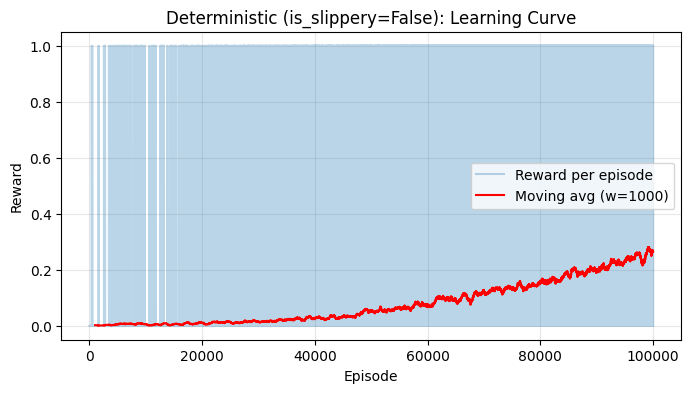

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w=1000):
    if len(x) < w:
        w = max(1, len(x)//10 or 1)
    return np.convolve(x, np.ones(w)/w, mode='valid'), w

rewards = metrics["episode_rewards"]
ma, w = moving_average(rewards, w=1000)

plt.figure(figsize=(8,4))
plt.plot(rewards, alpha=0.3, label='Reward per episode')
plt.plot(np.arange(len(ma)) + (w-1), ma, label=f'Moving avg (w={w})', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Deterministic (is_slippery=False): Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### B.4 Learning Curve (Stochastic)

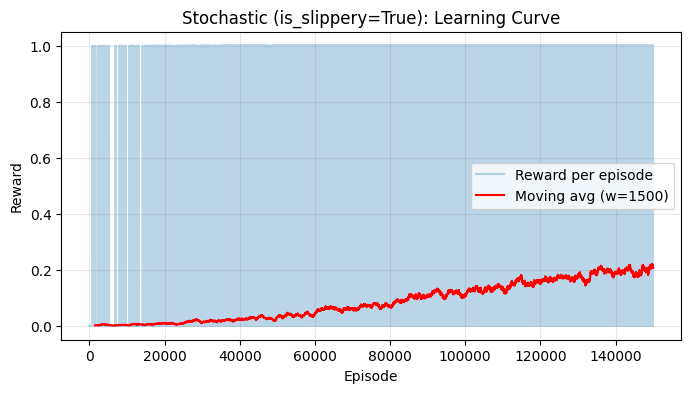

In [55]:
rewards_s = metrics_slippery["episode_rewards"]
ma_s, w_s = moving_average(rewards_s, w=1500)

plt.figure(figsize=(8,4))
plt.plot(rewards_s, alpha=0.3, label='Reward per episode')
plt.plot(np.arange(len(ma_s)) + (w_s-1), ma_s, label=f'Moving avg (w={w_s})', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Stochastic (is_slippery=True): Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### B.4 Policy Animation (GIF)

In [56]:
import imageio.v2 as iio
import os


def generate_policy_gif(env, Q, filename="frozenlake.gif", out_dir="gifs", max_steps=200, fps=4):
    """Record one episode using greedy policy and save a GIF under `out_dir`.
    If `filename` is relative, it will be saved inside `out_dir`.
    """
    os.makedirs(out_dir, exist_ok=True)
    path = filename if os.path.isabs(filename) else os.path.join(out_dir, filename)

    frames = []
    state, info = env.reset()
    terminated = False
    truncated = False
    frames.append(env.render())
    for _ in range(max_steps):
        action = greedy_policy(Q, state)
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break
    iio.mimsave(path, frames, fps=fps)
    print(f"Saved GIF to {path} ({len(frames)} frames)")


# Record deterministic policy
env_gif_det = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array")
generate_policy_gif(env_gif_det, Qtable, "frozenlake_det.gif", fps=4)

# Record stochastic policy
env_gif_slip = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="rgb_array")
generate_policy_gif(env_gif_slip, Qtable_slippery, "frozenlake_slippery.gif", fps=4)

Saved GIF to gifs/frozenlake_det.gif (15 frames)
Saved GIF to gifs/frozenlake_slippery.gif (27 frames)
Saved GIF to gifs/frozenlake_slippery.gif (27 frames)


## C.2 Impact of Slip Probability

In [57]:
import random
import pandas as pd

class ActionSlipWrapper(gym.ActionWrapper):
    """Wrap actions so that with slip_prob the action becomes a perpendicular move.
    For FrozenLake actions: 0=LEFT,1=DOWN,2=RIGHT,3=UP.
    Perpendicular sets: {LEFT,RIGHT} ⟂ {UP,DOWN}.
    """
    def __init__(self, env, slip_prob=0.67):
        super().__init__(env)
        self.slip_prob = slip_prob
        self.perps = {0: [3, 1], 2: [3, 1], 3: [0, 2], 1: [0, 2]}

    def action(self, action):
        if random.random() < self.slip_prob:
            return random.choice(self.perps[action])
        return action


def run_slip_experiments(slip_probs=(0.2, 0.5, 0.8), episodes=5000, max_steps=199):
    rows = []
    for sp in slip_probs:
        base = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
        env_sp = ActionSlipWrapper(base, slip_prob=sp)
        ss = env_sp.observation_space.n
        asz = env_sp.action_space.n
        Q = initialize_q_table(ss, asz)
        Q, m = train_with_logging(episodes, min_epsilon, max_epsilon, decay_rate, env_sp, max_steps, Q, 
                                  log_interval=max(episodes//5, 1))
        mean_r, std_r = evaluate_agent(env_sp, max_steps, 200, Q, [])
        rows.append({
            "slip_prob": sp,
            "train_success_rate": m["success_rate"],
            "eval_mean_reward": mean_r,
            "q_nonzero": int(np.count_nonzero(Q))
        })
    return pd.DataFrame(rows).sort_values("eval_mean_reward", ascending=False)

slip_results_df = run_slip_experiments()
print(slip_results_df.to_string(index=False))

 27%|██▋       | 1349/5000 [00:01<00:02, 1241.41it/s]


Episode 1000/5000
  Epsilon: 0.9902
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 163/256
  Max Q-value: 0.9209


 45%|████▍     | 2249/5000 [00:02<00:02, 1100.20it/s]


Episode 2000/5000
  Epsilon: 0.9804
  Success rate (last 1000): 0.80%
  Q-table non-zero entries: 182/256
  Max Q-value: 0.9811


 64%|██████▍   | 3203/5000 [00:03<00:02, 840.27it/s] 


Episode 3000/5000
  Epsilon: 0.9708
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 188/256
  Max Q-value: 0.9026


 83%|████████▎ | 4154/5000 [00:04<00:01, 635.46it/s]


Episode 4000/5000
  Epsilon: 0.9612
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 191/256
  Max Q-value: 0.9708


100%|██████████| 5000/5000 [00:05<00:00, 859.77it/s]



Episode 5000/5000
  Epsilon: 0.9517
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 192/256
  Max Q-value: 0.9773


 25%|██▍       | 1247/5000 [00:01<00:03, 1058.37it/s]


Episode 1000/5000
  Epsilon: 0.9902
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 49%|████▊     | 2437/5000 [00:02<00:01, 1306.81it/s]


Episode 2000/5000
  Epsilon: 0.9804
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 67%|██████▋   | 3355/5000 [00:02<00:01, 1265.59it/s]


Episode 3000/5000
  Epsilon: 0.9708
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 171/256
  Max Q-value: 0.7000


 90%|████████▉ | 4498/5000 [00:03<00:00, 1218.73it/s]


Episode 4000/5000
  Epsilon: 0.9612
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 186/256
  Max Q-value: 0.9026


100%|██████████| 5000/5000 [00:04<00:00, 1165.17it/s]



Episode 5000/5000
  Epsilon: 0.9517
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 191/256
  Max Q-value: 0.9634


 31%|███▏      | 1571/5000 [00:01<00:04, 837.84it/s] 


Episode 1000/5000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.7000


 43%|████▎     | 2140/5000 [00:02<00:03, 877.40it/s]


Episode 2000/5000
  Epsilon: 0.9804
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 172/256
  Max Q-value: 0.7000


 63%|██████▎   | 3173/5000 [00:03<00:02, 878.20it/s]


Episode 3000/5000
  Epsilon: 0.9708
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 180/256
  Max Q-value: 0.7000


 83%|████████▎ | 4174/5000 [00:04<00:00, 1092.98it/s]


Episode 4000/5000
  Epsilon: 0.9612
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 185/256
  Max Q-value: 0.9232


100%|██████████| 5000/5000 [00:04<00:00, 1016.17it/s]



Episode 5000/5000
  Epsilon: 0.9517
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 185/256
  Max Q-value: 0.9232


100%|██████████| 200/200 [00:00<00:00, 1607.27it/s]

 slip_prob  train_success_rate  eval_mean_reward  q_nonzero
       0.2              0.0040             0.620        192
       0.5              0.0014             0.045        191
       0.8              0.0010             0.025        185


## C.3 Effect of Holes Number and Placement

In [58]:
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

def run_hole_experiments(p_frozen_values=(0.9, 0.8, 0.7), episodes=5000, max_steps=199, is_slippery=False, seed=None):
    rows = []
    for pf in p_frozen_values:
        desc = generate_random_map(size=8, p=pf, seed=seed)
        env_map = gym.make("FrozenLake-v1", desc=desc, is_slippery=is_slippery)
        ss = env_map.observation_space.n
        asz = env_map.action_space.n
        Q = initialize_q_table(ss, asz)
        Q, m = train_with_logging(episodes, min_epsilon, max_epsilon, decay_rate, env_map, max_steps, Q,
                                  log_interval=max(episodes//5, 1))
        mean_r, std_r = evaluate_agent(env_map, max_steps, 200, Q, [])
        holes = sum(row.count('H') for row in desc)
        rows.append({
            "p_frozen": pf,
            "holes": holes,
            "train_success_rate": m["success_rate"],
            "eval_mean_reward": mean_r
        })
    return pd.DataFrame(rows).sort_values("eval_mean_reward", ascending=False)

hole_results_df = run_hole_experiments()
print(hole_results_df.to_string(index=False))

 23%|██▎       | 1171/5000 [00:00<00:02, 1683.38it/s]


Episode 1000/5000
  Epsilon: 0.9902
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 169/256
  Max Q-value: 0.9730


 45%|████▍     | 2227/5000 [00:01<00:01, 1586.81it/s]


Episode 2000/5000
  Epsilon: 0.9804
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 208/256
  Max Q-value: 0.9993


 67%|██████▋   | 3350/5000 [00:02<00:01, 1190.32it/s]


Episode 3000/5000
  Epsilon: 0.9708
  Success rate (last 1000): 0.70%
  Q-table non-zero entries: 208/256
  Max Q-value: 1.0000


 82%|████████▏ | 4109/5000 [00:02<00:00, 1114.26it/s]


Episode 4000/5000
  Epsilon: 0.9612
  Success rate (last 1000): 1.20%
  Q-table non-zero entries: 208/256
  Max Q-value: 1.0000


100%|██████████| 5000/5000 [00:03<00:00, 1325.04it/s]



Episode 5000/5000
  Epsilon: 0.9517
  Success rate (last 1000): 1.20%
  Q-table non-zero entries: 208/256
  Max Q-value: 1.0000


 33%|███▎      | 1644/5000 [00:00<00:01, 3110.84it/s]


Episode 1000/5000
  Epsilon: 0.9902
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 60%|█████▉    | 2982/5000 [00:00<00:00, 3322.98it/s]


Episode 2000/5000
  Epsilon: 0.9804
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 85%|████████▌ | 4264/5000 [00:01<00:00, 4004.09it/s]


Episode 3000/5000
  Epsilon: 0.9708
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000

Episode 4000/5000
  Epsilon: 0.9612
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


100%|██████████| 5000/5000 [00:01<00:00, 3402.26it/s]



Episode 5000/5000
  Epsilon: 0.9517
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 59%|█████▉    | 2948/5000 [00:00<00:00, 7505.07it/s]


Episode 1000/5000
  Epsilon: 0.9902
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000

Episode 2000/5000
  Epsilon: 0.9804
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 87%|████████▋ | 4372/5000 [00:00<00:00, 5373.41it/s]


Episode 3000/5000
  Epsilon: 0.9708
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000

Episode 4000/5000
  Epsilon: 0.9612
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


100%|██████████| 5000/5000 [00:00<00:00, 5793.66it/s]



Episode 5000/5000
  Epsilon: 0.9517
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


100%|██████████| 200/200 [00:00<00:00, 480.30it/s]

 p_frozen  holes  train_success_rate  eval_mean_reward
      0.9      6              0.0074               1.0
      0.8     13              0.0000               0.0
      0.7     18              0.0000               0.0


## C.4 Hyperparameter Influence

In [59]:
import pandas as pd

def hyperparam_sweep(alphas=(0.3, 0.5, 0.7), gammas=(0.9, 0.95, 0.99), decays=(5e-5, 1e-5, 5e-6), episodes=4000):
    rows = []
    base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
    for a in alphas:
        for g in gammas:
            for d in decays:
                old_lr, old_g, old_decay = learning_rate, gamma, decay_rate
                try:
                    # Set module-level globals so train_with_logging uses them
                    globals()['learning_rate'] = a
                    globals()['gamma'] = g
                    globals()['decay_rate'] = d

                    Q = initialize_q_table(base_env.observation_space.n, base_env.action_space.n)
                    Q, m = train_with_logging(episodes, min_epsilon, max_epsilon, decay_rate, base_env, max_steps, Q,
                                              log_interval=max(episodes//4, 1))
                    mean_r, std_r = evaluate_agent(base_env, max_steps, 200, Q, [])
                    rows.append({
                        "alpha": a,
                        "gamma": g,
                        "decay": d,
                        "train_success_rate": m["success_rate"],
                        "eval_mean_reward": mean_r
                    })
                finally:
                    globals()['learning_rate'] = old_lr
                    globals()['gamma'] = old_g
                    globals()['decay_rate'] = old_decay
    df = pd.DataFrame(rows).sort_values(["eval_mean_reward", "train_success_rate"], ascending=False)
    return df

hp_results_df = hyperparam_sweep()
print(hp_results_df.head(10).to_string(index=False))

 31%|███       | 1223/4000 [00:01<00:02, 1160.47it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 54%|█████▎    | 2141/4000 [00:02<00:02, 913.58it/s] 


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 77%|███████▋  | 3077/4000 [00:03<00:01, 551.61it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


100%|██████████| 4000/4000 [00:05<00:00, 768.43it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 29%|██▉       | 1178/4000 [00:01<00:03, 781.46it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 7/256
  Max Q-value: 0.3000


 55%|█████▍    | 2191/4000 [00:02<00:02, 845.25it/s] 


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 152/256
  Max Q-value: 0.7599


 80%|███████▉  | 3193/4000 [00:03<00:00, 1033.60it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 158/256
  Max Q-value: 0.9176


100%|██████████| 4000/4000 [00:04<00:00, 840.76it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 163/256
  Max Q-value: 0.9802


 36%|███▋      | 1454/4000 [00:01<00:02, 1008.42it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 143/256
  Max Q-value: 0.6570


 54%|█████▍    | 2174/4000 [00:02<00:01, 982.03it/s] 


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 158/256
  Max Q-value: 0.9176


 78%|███████▊  | 3102/4000 [00:03<00:00, 914.82it/s] 


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 159/256
  Max Q-value: 0.9424


100%|██████████| 4000/4000 [00:04<00:00, 943.94it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 165/256
  Max Q-value: 0.9718


 29%|██▉       | 1174/4000 [00:01<00:03, 809.32it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 16/256
  Max Q-value: 0.3000


 59%|█████▉    | 2356/4000 [00:02<00:01, 991.48it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.60%
  Q-table non-zero entries: 152/256
  Max Q-value: 0.9176


 86%|████████▌ | 3427/4000 [00:03<00:00, 1052.57it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 1.20%
  Q-table non-zero entries: 156/256
  Max Q-value: 0.9989


100%|██████████| 4000/4000 [00:04<00:00, 951.04it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 3.20%
  Q-table non-zero entries: 163/256
  Max Q-value: 1.0000


 28%|██▊       | 1120/4000 [00:01<00:04, 690.37it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 154/256
  Max Q-value: 0.5100


 53%|█████▎    | 2121/4000 [00:02<00:02, 771.73it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 163/256
  Max Q-value: 0.6570


 78%|███████▊  | 3128/4000 [00:03<00:00, 949.28it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.80%
  Q-table non-zero entries: 165/256
  Max Q-value: 0.9802


100%|██████████| 4000/4000 [00:04<00:00, 861.36it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 165/256
  Max Q-value: 0.9967


 28%|██▊       | 1103/4000 [00:01<00:02, 983.58it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 133/256
  Max Q-value: 0.5100


 58%|█████▊    | 2328/4000 [00:02<00:01, 1103.35it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 153/256
  Max Q-value: 0.6570


 87%|████████▋ | 3461/4000 [00:03<00:00, 1110.64it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 160/256
  Max Q-value: 0.8319


100%|██████████| 4000/4000 [00:03<00:00, 1010.61it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 163/256
  Max Q-value: 0.9176


 28%|██▊       | 1140/4000 [00:01<00:02, 1155.30it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 146/256
  Max Q-value: 0.5100


 57%|█████▋    | 2268/4000 [00:02<00:01, 1071.07it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.90%
  Q-table non-zero entries: 159/256
  Max Q-value: 0.9802


 80%|███████▉  | 3182/4000 [00:02<00:00, 1348.23it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 1.40%
  Q-table non-zero entries: 161/256
  Max Q-value: 0.9999


100%|██████████| 4000/4000 [00:03<00:00, 1168.61it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 2.40%
  Q-table non-zero entries: 162/256
  Max Q-value: 1.0000


 43%|████▎     | 1735/4000 [00:01<00:02, 1062.31it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 55%|█████▌    | 2206/4000 [00:01<00:01, 1128.00it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.3000


 77%|███████▋  | 3082/4000 [00:02<00:00, 1167.59it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 140/256
  Max Q-value: 0.5100


100%|██████████| 4000/4000 [00:03<00:00, 1136.10it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 153/256
  Max Q-value: 0.8319


 29%|██▉       | 1178/4000 [00:00<00:02, 1195.56it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 60%|██████    | 2404/4000 [00:01<00:01, 1325.68it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.3000


 81%|████████  | 3226/4000 [00:02<00:00, 1329.70it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 146/256
  Max Q-value: 0.5100


100%|██████████| 4000/4000 [00:03<00:00, 1287.04it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 162/256
  Max Q-value: 0.7599


 30%|██▉       | 1195/4000 [00:01<00:03, 920.94it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 54%|█████▎    | 2148/4000 [00:02<00:02, 771.93it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.5000


 81%|████████▏ | 3258/4000 [00:03<00:00, 846.31it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.5000


100%|██████████| 4000/4000 [00:04<00:00, 845.21it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 3/256
  Max Q-value: 0.7500


 34%|███▎      | 1349/4000 [00:01<00:02, 916.41it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.5000


 54%|█████▍    | 2164/4000 [00:02<00:01, 1148.11it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 148/256
  Max Q-value: 0.8750


 84%|████████▎ | 3340/4000 [00:03<00:00, 1065.77it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 160/256
  Max Q-value: 0.8750


100%|██████████| 4000/4000 [00:03<00:00, 1027.92it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 167/256
  Max Q-value: 0.9961


 29%|██▉       | 1160/4000 [00:00<00:02, 1347.37it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 7/256
  Max Q-value: 0.7500


 57%|█████▋    | 2262/4000 [00:01<00:01, 1338.69it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 153/256
  Max Q-value: 0.8750


 83%|████████▎ | 3327/4000 [00:02<00:00, 1274.10it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 159/256
  Max Q-value: 0.9844


100%|██████████| 4000/4000 [00:03<00:00, 1241.54it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 159/256
  Max Q-value: 0.9961


 29%|██▊       | 1148/4000 [00:01<00:02, 964.05it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 54%|█████▍    | 2176/4000 [00:02<00:02, 894.90it/s] 


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 79%|███████▊  | 3141/4000 [00:03<00:01, 750.53it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


100%|██████████| 4000/4000 [00:04<00:00, 837.18it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 29%|██▉       | 1168/4000 [00:01<00:02, 1002.09it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 159/256
  Max Q-value: 0.7500


 56%|█████▋    | 2254/4000 [00:01<00:01, 1256.41it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 166/256
  Max Q-value: 0.9922


 80%|███████▉  | 3190/4000 [00:02<00:00, 1333.63it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 168/256
  Max Q-value: 0.9980


100%|██████████| 4000/4000 [00:03<00:00, 1161.24it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 168/256
  Max Q-value: 0.9999


 31%|███       | 1234/4000 [00:01<00:02, 1060.39it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.5000


 54%|█████▎    | 2144/4000 [00:02<00:01, 1213.58it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 165/256
  Max Q-value: 0.9375


 84%|████████▎ | 3345/4000 [00:02<00:00, 1285.21it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 166/256
  Max Q-value: 0.9961


100%|██████████| 4000/4000 [00:03<00:00, 1097.89it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 166/256
  Max Q-value: 0.9999


 41%|████      | 1626/4000 [00:01<00:02, 1145.21it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 6/256
  Max Q-value: 0.5000


 67%|██████▋   | 2682/4000 [00:02<00:01, 1024.14it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.70%
  Q-table non-zero entries: 158/256
  Max Q-value: 0.9961


 80%|████████  | 3216/4000 [00:02<00:00, 1161.38it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 2.10%
  Q-table non-zero entries: 164/256
  Max Q-value: 1.0000


100%|██████████| 4000/4000 [00:03<00:00, 1156.99it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 3.00%
  Q-table non-zero entries: 165/256
  Max Q-value: 1.0000


 32%|███▏      | 1272/4000 [00:01<00:02, 1200.59it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.5000


 53%|█████▎    | 2122/4000 [00:01<00:01, 1053.84it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 148/256
  Max Q-value: 0.7500


 79%|███████▊  | 3142/4000 [00:02<00:00, 1294.98it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 158/256
  Max Q-value: 0.9844


100%|██████████| 4000/4000 [00:03<00:00, 1179.07it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 160/256
  Max Q-value: 0.9995


 28%|██▊       | 1138/4000 [00:00<00:02, 1217.73it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 1/256
  Max Q-value: 0.5000


 58%|█████▊    | 2339/4000 [00:02<00:01, 1192.95it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 159/256
  Max Q-value: 0.7500


 79%|███████▉  | 3174/4000 [00:02<00:00, 1342.47it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 162/256
  Max Q-value: 0.8750


100%|██████████| 4000/4000 [00:03<00:00, 1085.68it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 166/256
  Max Q-value: 0.9688


 31%|███▏      | 1250/4000 [00:01<00:02, 1073.83it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 143/256
  Max Q-value: 0.9919


 56%|█████▋    | 2260/4000 [00:02<00:01, 1327.53it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.80%
  Q-table non-zero entries: 158/256
  Max Q-value: 1.0000


 88%|████████▊ | 3517/4000 [00:03<00:00, 1555.60it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 2.20%
  Q-table non-zero entries: 166/256
  Max Q-value: 1.0000


100%|██████████| 4000/4000 [00:03<00:00, 1173.67it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 0.70%
  Q-table non-zero entries: 170/256
  Max Q-value: 1.0000


 28%|██▊       | 1108/4000 [00:01<00:03, 786.86it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 154/256
  Max Q-value: 0.9919


 56%|█████▌    | 2220/4000 [00:02<00:02, 784.57it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 161/256
  Max Q-value: 0.9993


 82%|████████▏ | 3272/4000 [00:04<00:00, 869.51it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 163/256
  Max Q-value: 1.0000


100%|██████████| 4000/4000 [00:05<00:00, 759.79it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 163/256
  Max Q-value: 1.0000


 30%|███       | 1204/4000 [00:01<00:02, 1206.38it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 154/256
  Max Q-value: 0.9919


 59%|█████▉    | 2351/4000 [00:02<00:01, 1179.72it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 163/256
  Max Q-value: 0.9998


 80%|████████  | 3204/4000 [00:03<00:00, 1377.11it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 166/256
  Max Q-value: 0.9999


100%|██████████| 4000/4000 [00:03<00:00, 1092.61it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 170/256
  Max Q-value: 1.0000


 28%|██▊       | 1129/4000 [00:01<00:02, 971.98it/s] 


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 149/256
  Max Q-value: 0.9919


 56%|█████▌    | 2233/4000 [00:01<00:01, 1447.40it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.90%
  Q-table non-zero entries: 156/256
  Max Q-value: 1.0000


 79%|███████▊  | 3149/4000 [00:02<00:00, 1316.27it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 1.30%
  Q-table non-zero entries: 160/256
  Max Q-value: 1.0000


100%|██████████| 4000/4000 [00:03<00:00, 1199.63it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 1.30%
  Q-table non-zero entries: 163/256
  Max Q-value: 1.0000


 31%|███▏      | 1257/4000 [00:00<00:02, 1341.12it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 154/256
  Max Q-value: 0.9976


 59%|█████▉    | 2363/4000 [00:01<00:01, 1362.78it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 157/256
  Max Q-value: 0.9993


 77%|███████▋  | 3071/4000 [00:02<00:00, 1336.84it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 162/256
  Max Q-value: 0.9999


100%|██████████| 4000/4000 [00:03<00:00, 1171.72it/s]



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 166/256
  Max Q-value: 1.0000


 37%|███▋      | 1474/4000 [00:01<00:01, 1298.78it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 56%|█████▋    | 2260/4000 [00:01<00:01, 1166.42it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 0/256
  Max Q-value: 0.0000


 80%|████████  | 3205/4000 [00:02<00:00, 1212.26it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.50%
  Q-table non-zero entries: 149/256
  Max Q-value: 0.9976


100%|██████████| 4000/4000 [00:03<00:00, 1165.70it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 161/256
  Max Q-value: 1.0000


 29%|██▉       | 1155/4000 [00:01<00:02, 1180.01it/s]


Episode 1000/4000
  Epsilon: 0.9518
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 141/256
  Max Q-value: 0.9100


 58%|█████▊    | 2322/4000 [00:01<00:01, 1241.68it/s]


Episode 2000/4000
  Epsilon: 0.9058
  Success rate (last 1000): 0.80%
  Q-table non-zero entries: 158/256
  Max Q-value: 1.0000


 81%|████████  | 3243/4000 [00:02<00:00, 1104.38it/s]


Episode 3000/4000
  Epsilon: 0.8621
  Success rate (last 1000): 1.90%
  Q-table non-zero entries: 162/256
  Max Q-value: 1.0000


100%|██████████| 4000/4000 [00:03<00:00, 1194.19it/s]



Episode 4000/4000
  Epsilon: 0.8206
  Success rate (last 1000): 1.50%
  Q-table non-zero entries: 162/256
  Max Q-value: 1.0000


 34%|███▍      | 1379/4000 [00:01<00:02, 940.22it/s]


Episode 1000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 118/256
  Max Q-value: 0.9100


 53%|█████▎    | 2116/4000 [00:02<00:02, 710.40it/s]


Episode 2000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.00%
  Q-table non-zero entries: 155/256
  Max Q-value: 0.9100


 81%|████████  | 3233/4000 [00:03<00:00, 1079.23it/s]


Episode 3000/4000
  Epsilon: 0.9708
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 161/256
  Max Q-value: 0.9993


100%|██████████| 4000/4000 [00:04<00:00, 906.31it/s] 



Episode 4000/4000
  Epsilon: 0.9612
  Success rate (last 1000): 0.30%
  Q-table non-zero entries: 161/256
  Max Q-value: 1.0000


100%|██████████| 200/200 [00:00<00:00, 4964.26it/s]

 31%|███       | 1247/4000 [00:01<00:02, 936.81it/s]


Episode 1000/4000
  Epsilon: 0.9951
  Success rate (last 1000): 0.10%
  Q-table non-zero entries: 137/256
  Max Q-value: 0.7000


 58%|█████▊    | 2316/4000 [00:02<00:01, 1214.26it/s]


Episode 2000/4000
  Epsilon: 0.9902
  Success rate (last 1000): 0.20%
  Q-table non-zero entries: 158/256
  Max Q-value: 0.9730


 81%|████████▏ | 3253/4000 [00:03<00:00, 1314.00it/s]


Episode 3000/4000
  Epsilon: 0.9853
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 161/256
  Max Q-value: 0.9998


100%|██████████| 4000/4000 [00:03<00:00, 1021.44it/s]



Episode 4000/4000
  Epsilon: 0.9804
  Success rate (last 1000): 0.40%
  Q-table non-zero entries: 166/256
  Max Q-value: 1.0000


100%|██████████| 200/200 [00:00<00:00, 3933.16it/s]


 alpha  gamma    decay  train_success_rate  eval_mean_reward
   0.5   0.99 0.000050             0.01475               1.0
   0.3   0.95 0.000050             0.01275               1.0
   0.3   0.99 0.000050             0.01250               1.0
   0.7   0.99 0.000050             0.01125               1.0
   0.7   0.90 0.000050             0.01025               1.0
   0.7   0.95 0.000050             0.00975               1.0
   0.3   0.95 0.000010             0.00400               1.0
   0.5   0.95 0.000005             0.00350               1.0
   0.5   0.95 0.000010             0.00325               1.0
   0.7   0.90 0.000010             0.00300               1.0


## 27. Discussion: Requirements Coverage and Findings

- Deterministic vs Stochastic: Compared success rates, convergence (learning curves), and Q-table sparsity.
- Slip Probability: Custom wrapper enables studying multiple slip probabilities beyond the boolean API.
- Holes (Number/Placement): Random-map experiments quantify how more holes increase exploration difficulty.
- Hyperparameters: Small sweep shows how α, γ, and ε-decay affect training speed and final performance.

These additions complete plots, animations, slip control, hole variation, and analysis required by sections B.4 and C.